In [1]:
# some code implemented from youtube tutorial from Madhav Thaker
# https://github.com/madhavthaker/spotify-recommendation-system

TODO:
Finish creating recommendations and add for example nlp, one hot encoding and more.

Create a like system from recommendations

In [2]:
import pandas as pd
import numpy as np
import json
from IPython.display import Image
from IPython.core.display import display, HTML
import itertools
import sys
import re
import os
import matplotlib.pyplot as plt
from skimage import io
from IPython.display import Image


# Spotipy
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.oauth2 import SpotifyOAuth
import spotipy.util as util

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
display(HTML("<style>.container { width:95% !important; }</style>"))
pd.set_option('display.max_columns', None)
pd.set_option("max_rows", None)

#prediction
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler

url = os.getcwd()

## Extra

In [3]:
from secrets import client_id, client_secret

scope = 'user-library-read'

if len(sys.argv) > 1:
    username = sys.argv[1]
else:
    print("Usage: %s username" % (sys.argv[0],))
    sys.exit()

# Spotify access
auth_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(auth_manager=auth_manager)

token = util.prompt_for_user_token(scope, client_id= client_id, client_secret=client_secret, redirect_uri='http://localhost:8881/')
sp = spotipy.Spotify(auth=token)
spotify_username = sp.current_user()['id']

In [4]:
# display function that was show in a youtube tutorial from Madhav Thaker
def cover_songs(df):
    image_url = df['image_url'].values
    plt.figure(figsize=(15,int(0.625 * len(image_url))))
    columns = 5
    
    for i, url in enumerate(image_url):
        plt.subplot(len(image_url) / columns + 1, columns, i + 1)

        image = io.imread(url)
        plt.imshow(image)
        plt.xticks(color = 'w', fontsize = 0.1)
        plt.yticks(color = 'w', fontsize = 0.1)
        plt.xlabel(df['name'].values[i], fontsize = 12)
        plt.tight_layout(h_pad=0.4, w_pad=0)
        plt.subplots_adjust(wspace=None, hspace=None)

    plt.show()

## Gathering data

In [5]:
def get_users_playlists():
    playlist_names = {}
    playlist_photos = {}
    
    for i in sp.current_user_playlists()['items']:
        playlist_names[i['name']] = i['uri'].split(':')[2]
        playlist_photos[i['uri'].split(':')[2]] = i['images'][0]['url']
    
    return playlist_names, playlist_photos

# Call get_users_playlists()
playlist_names, playlist_photos = get_users_playlists()

# Here are all your playlist, copy the playlist id you want to choose songs from
playlist_names

{'New Playlist 2': '5e8ijEDzlaB0y9apSoZNBI',
 'Tyler Bates – The Punisher (Original Soundtrack) 2': '3qt3t2qfyWSli9F6C9C3SF',
 'Globus – Epicon (UK Version)': '25sJ1ieBzb2AVPS9GaZhKm',
 's': '2L0LTJqWOFFI8qPqkDVjKG',
 'Immediate – Trailerhead: Triumph': '71DD8rTMqJB4bnFRdS1Jz7',
 'Electric Romeo – Immediate': '2aL9qUB2A6vc72I4AwrWlt',
 'Highway man': '4thvxQYvACp32gZguRAiEw',
 'party mood': '7MIO3PrQ0ZXdPobIpHOc5a',
 'Southpaw (Music From And Inspired By The Motion Picture)': '0kF5WxQpwIlFG130bWovut',
 'Work Hard, Play Hard – Wiz Khalifa': '1CavHtskIP3Dp0r9RCwXpY',
 'From edits': '5Yi5I6uqMn9oyV3RhvUVNm',
 'beuty': '7K0flcn5YDOXxPRhChKzre',
 'OAZ': '0RVTSPELkBvNXUw27BUC0R',
 'Eyeex': '2zqTk2BwhJx4CaqhwZ40RK',
 'Icelandic Music | Ragnarsmedia': '2eyFd9OYGYRFG1WknFYfTy',
 'Íslenskt': '4jp0RPWEON6B3hbLu6f1N4',
 'Grime ': '3VsZqGKOP5E6pcixUKg8zt',
 'Ultra 1.0': '0fQrVALjgMV5ckiOG6Lw0u',
 'Ultra 2.0': '6N1CYumwsQ6hScprqxmfsL',
 'Ultra 3.0': '1thpoCGLWqyLpPMFli6dHD',
 '21': '3WCO6yNpxaBEtRVT

In [6]:
def get_playlist_tracks(username,playlist_id):
    results = sp.user_playlist_tracks(username,playlist_id)
    tracks = results['items']
    while results['next']:
        results = sp.next(results)
        tracks.extend(results['items'])
    return tracks

In [7]:
## Song Audio Features
#sp.audio_features("17DjxJJG1NHXg1VatxfFfU")
def get_track_features(track_id):
    audio_features = sp.audio_features(track_id)[0]
    track_out = {
        'acousticness': audio_features['acousticness'],
        'danceability': audio_features['danceability'],
        'duration_ms': audio_features['duration_ms'],
        'energy': audio_features['energy'],
        'instrumentalness': audio_features['instrumentalness'],
        'liveness': audio_features['liveness'],
        'loudness': audio_features['loudness'],
        'mode': audio_features['mode'],
        'speechiness': audio_features['speechiness'],
        'tempo': audio_features['tempo'],
        'valence': audio_features['valence']
    }
    return track_out

In [8]:
def get_track_info(playlist_id, tracks, number):
    # Track
    track = tracks[number]
    added_by = track['added_by']['id']
    track_info = track['track']
    track_artist = track_info['artists'][0]
    track_album = track_info['album']

    # Informations about the track
    id = track_info['id']
    name = track_info['name']
    date_added = track['added_at']
    explicit = track_info['explicit']
    popularity = track_info['popularity']
    link = track_info['external_urls']['spotify']
    preview_url = track_info['preview_url']
    image_url = track_album['images'][1]['url']
    release_date = track_album["release_date"]
    
    # Informations about the artists
    artist_id = track_artist['id']
    artist_name = track_artist['name']
    
    ## audio features
    audio_features = sp.audio_features(id)[0]
    #print(audio_features)
    #track_features = get_track_features(id) 
    
    album_genres = sp.album(track_album['id'])
    #print("album genres:", album_genres)
    
    #'playlist_id': playlist_id,
    #'date_added': date_added,
    track_out = {
        'id': id,
        'name': name,
        'link': link,
        'popularity': popularity,
        'image_url': image_url,
        'preview_url': preview_url,
        'artist_id': artist_id,
        'artist_name': artist_name,
        'explicit': explicit,
        'release_date': release_date,
        'acousticness': audio_features['acousticness'],
        'danceability': audio_features['danceability'],
        'duration_ms': audio_features['duration_ms'],
        'energy': audio_features['energy'],
        'instrumentalness': audio_features['instrumentalness'],
        'liveness': audio_features['liveness'],
        'loudness': audio_features['loudness'],
        'mode': audio_features['mode'],
        'speechiness': audio_features['speechiness'],
        'tempo': audio_features['tempo'],
        'valence': audio_features['valence']
    }

    return track_out
 
#genre_seeds = sp.recommendation_genre_seeds()
#genres = genre_seeds['genres']

#test_track_info = specific_playlist_songs("5Yi5I6uqMn9oyV3RhvUVNm")
#test_track_info

In [9]:
def specific_playlist_songs(id_playlist):
    track_info = []
    for playlist_name, playlist_id in playlist_names.items():
        if(str(playlist_id) == id_playlist):
            tracks = get_playlist_tracks(spotify_username, playlist_id)
            for track_number in range(0, len(tracks)):
                track_info.append(get_track_info(playlist_id, tracks, track_number))
    return pd.DataFrame(track_info)

In [10]:
''' 
## I never finished implementing this function: 
## Maybe future work
def get_all_playlist_songs():
    track_info = []
    for playlist_name, playlist_id in playlist_names.items():
        tracks = get_playlist_tracks(spotify_username, playlist_id)
        for track_number in range(0, len(tracks)):
            track_info.append(get_track_info(playlist_id, tracks, track_number))
    return pd.DataFrame(track_info)    
'''

' \n## I never finished implementing this function: \n## Maybe future work\ndef get_all_playlist_songs():\n    track_info = []\n    for playlist_name, playlist_id in playlist_names.items():\n        tracks = get_playlist_tracks(spotify_username, playlist_id)\n        for track_number in range(0, len(tracks)):\n            track_info.append(get_track_info(playlist_id, tracks, track_number))\n    return pd.DataFrame(track_info)    \n'

In [11]:
## Creating playlist tracks
from_edits_playlist = specific_playlist_songs("5Yi5I6uqMn9oyV3RhvUVNm")
from_isx_playlist = specific_playlist_songs("4jp0RPWEON6B3hbLu6f1N4")

# Change here for your playlist id
#custom = specific_playlist_songs("0RVTSPELkBvNXUw27BUC0R")

In [12]:
from_oaz = specific_playlist_songs("0RVTSPELkBvNXUw27BUC0R")

## Visualize the data

In [13]:
## Uncomment to visually see the dataframe
#from_edits_playlist
#from_edits_playlist
#beuty
#custom

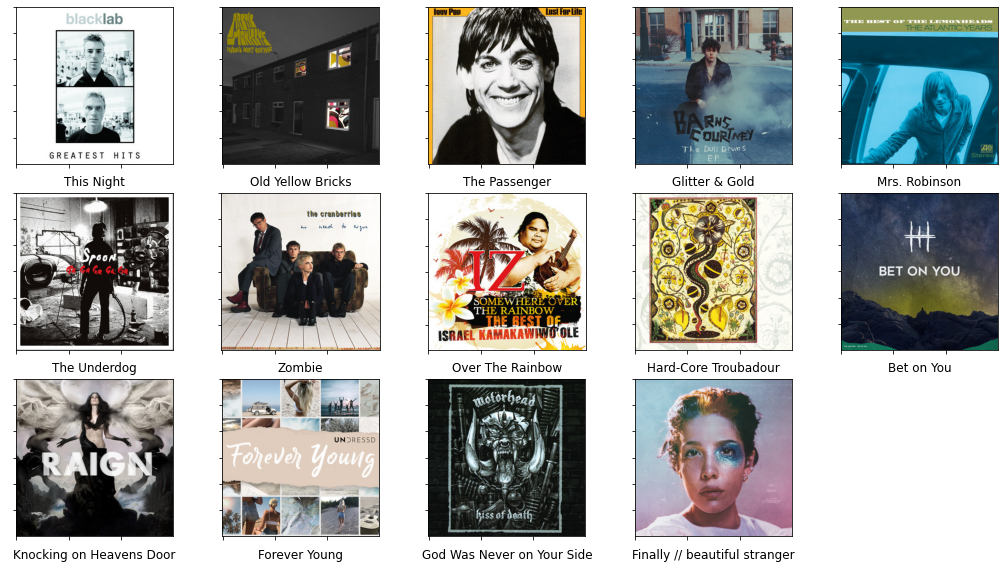

In [14]:
cover_songs(from_edits_playlist)
#cover_songs(from_isx_playlist)
#cover_songs(from_oaz)

In [15]:
## from_oaz.head()

## Predicting data

In [16]:
def create_clean_copy(df):
    df["year"] = df['release_date'].apply(lambda x: x.split('-')[0])
    df = df.drop(columns = ['duration_ms', 'link', 'image_url', 'preview_url', 'artist_id', 'artist_name', 'release_date'])
    return df

In [17]:
# change original_playlist = to the dataframe you want to use
original_playlist = from_oaz
clean_playlist = create_clean_copy(original_playlist)

In [18]:
def predict_data_first(df):
    X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['name', 'id']), df['id'], test_size=0.30)
    clf = make_pipeline(StandardScaler(), OneClassSVM(nu = 0.11, gamma=0.04))
    clf.fit(X_train, y_train)
    
    predictions = clf.predict(X_test)
    outliers = [id for id, predict in zip(y_test, predictions) if predict < 0]
    count = len(outliers)
    return predictions, outliers, count, y_test

In [19]:
predictions, outliers, count, y_test = predict_data_first(clean_playlist)
outlier_temp_playlist = original_playlist.loc[clean_playlist['id'].isin(outliers)].to_json(orient='index')

# print results
print(outlier_temp_playlist)
print("test outliers count: " + str(count))
print("test outliers %:" +  str({count/len(y_test)*100}))

{"18":{"id":"3rBHNlOJqNQM7rtxHJvPNV","name":"Unsteady","link":"https:\/\/open.spotify.com\/track\/3rBHNlOJqNQM7rtxHJvPNV","popularity":0,"image_url":"https:\/\/i.scdn.co\/image\/ab67616d00001e02029bd729329afc3a775392a9","preview_url":null,"artist_id":"4JDAk2gUKYlvSOMmkTvY2p","artist_name":"Ollie","explicit":true,"release_date":"2016-07-26","acousticness":0.122,"danceability":0.76,"duration_ms":234031,"energy":0.48,"instrumentalness":0.00000183,"liveness":0.208,"loudness":-14.607,"mode":1,"speechiness":0.0536,"tempo":116.968,"valence":0.276,"year":"2016"},"24":{"id":"7rWwv1ePazmRzmJs4sARhI","name":"Can't Tell Me Nothing","link":"https:\/\/open.spotify.com\/track\/7rWwv1ePazmRzmJs4sARhI","popularity":0,"image_url":"https:\/\/i.scdn.co\/image\/ab67616d00001e028c9c18cd0509e90c5d5e3c52","preview_url":null,"artist_id":"5K4W6rqBFWDnAN6FQUkS6x","artist_name":"Kanye West","explicit":true,"release_date":"2007-09-11","acousticness":0.0122,"danceability":0.596,"duration_ms":271600,"energy":0.62,"i

In [20]:
outliers_df = pd.DataFrame(json.loads(outlier_temp_playlist)).T
outliers_df

,id,name,link,popularity,image_url,preview_url,artist_id,artist_name,explicit,release_date,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,mode,speechiness,tempo,valence,year
18,3rBHNlOJqNQM7rtxHJvPNV,Unsteady,https://open.spotify.com/track/3rBHNlOJqNQM7rt...,0,https://i.scdn.co/image/ab67616d00001e02029bd7...,None,4JDAk2gUKYlvSOMmkTvY2p,Ollie,True,2016-07-26,0.122,0.76,234031,0.48,0.000002,0.208,-14.607,1,0.0536,116.968,0.276,2016
24,7rWwv1ePazmRzmJs4sARhI,Can't Tell Me Nothing,https://open.spotify.com/track/7rWwv1ePazmRzmJ...,0,https://i.scdn.co/image/ab67616d00001e028c9c18...,None,5K4W6rqBFWDnAN6FQUkS6x,Kanye West,True,2007-09-11,0.0122,0.596,271600,0.62,0.0,0.82,-6.133,0,0.039,80.029,0.102,2007
28,3jk4tqdnx2XfGqto37o25Z,Interweb,https://open.spotify.com/track/3jk4tqdnx2XfGqt...,0,https://i.scdn.co/image/ab67616d00001e02b17e84...,None,5mlbvTfWUOfDrUIK6dkNzv,Poppy,False,2017-07-17,0.0103,0.871,229619,0.509,0.463,0.0786,-5.531,1,0.0391,113.995,0.648,2017
44,1Jmqubf9kGkWeYQXQKImL5,People Are Strange,https://open.spotify.com/track/1Jmqubf9kGkWeYQ...,72,https://i.scdn.co/image/ab67616d00001e0286339e...,https://p.scdn.co/mp3-preview/f63e989a2e7d5c11...,22WZ7M8sxp5THdruNY3gXt,The Doors,False,1967-09-25,0.685,0.699,130173,0.467,0.0,0.315,-8.578,0,0.0375,119.287,0.764,1967
51,1k1Bqnv2R0uJXQN4u6LKYt,Ain't No Sunshine,https://open.spotify.com/track/1k1Bqnv2R0uJXQN...,79,https://i.scdn.co/image/ab67616d00001e02e1e350...,https://p.scdn.co/mp3-preview/2f56920743ab7da6...,1ThoqLcyIYvZn7iWbj8fsj,Bill Withers,False,1971-05-01,0.457,0.527,125093,0.415,0.000017,0.117,-11.451,0,0.122,78.169,0.515,1971
91,2Xqd0wUttjueBfdcltADOv,No Limit,https://open.spotify.com/track/2Xqd0wUttjueBfd...,1,https://i.scdn.co/image/ab67616d00001e0230e131...,None,02kJSzxNuaWGqwubyUba0Z,G-Eazy,True,2017-09-07,0.0117,0.838,245387,0.771,0.0,0.0853,-3.791,1,0.244,175.957,0.405,2017
111,2anqvLXhJRNLJC6K4XD0Mj,Disparate Youth,https://open.spotify.com/track/2anqvLXhJRNLJC6...,39,https://i.scdn.co/image/ab67616d00001e027df170...,https://p.scdn.co/mp3-preview/25b3e506c1b2542e...,6Jrxnp0JgqmeUX1veU591p,Santigold,False,2012-03-09,0.0131,0.642,284400,0.931,0.825,0.215,-4.142,1,0.0417,152.005,0.548,2012
143,0cON9blGpAWOsecmThlqUN,Welcome to the Black Parade - Steve Aoki 10th ...,https://open.spotify.com/track/0cON9blGpAWOsec...,0,https://i.scdn.co/image/ab67616d00001e024d5bf1...,None,7FBcuc1gsnv6Y1nwFtNRCb,My Chemical Romance,False,2016-11-28,0.00479,0.503,210000,0.902,0.000003,0.083,-2.215,1,0.0704,160.105,0.384,2016
185,3AgjOKGhzEQgdATLf0N68d,Oh My Gah (Remix),https://open.spotify.com/track/3AgjOKGhzEQgdAT...,0,https://i.scdn.co/image/ab67616d00001e022ff6c4...,None,7vGkwxpdjmp2UoWRIfqrVc,Party in Backyard,False,2017-10-25,0.565,0.659,90674,0.89,0.0,0.153,-3.952,0,0.217,179.985,0.864,2017
207,0wJoRiX5K5BxlqZTolB2LD,Purple Haze,https://open.spotify.com/track/0wJoRiX5K5BxlqZ...,73,https://i.scdn.co/image/ab67616d00001e02c9adfb...,https://p.scdn.co/mp3-preview/03bc9eb9c20f832c...,776Uo845nYHJpNaStv1Ds4,Jimi Hendrix,False,1967-05-12,0.00876,0.533,170813,0.905,0.578,0.0698,-5.27,1,0.0754,108.9,0.486,1967


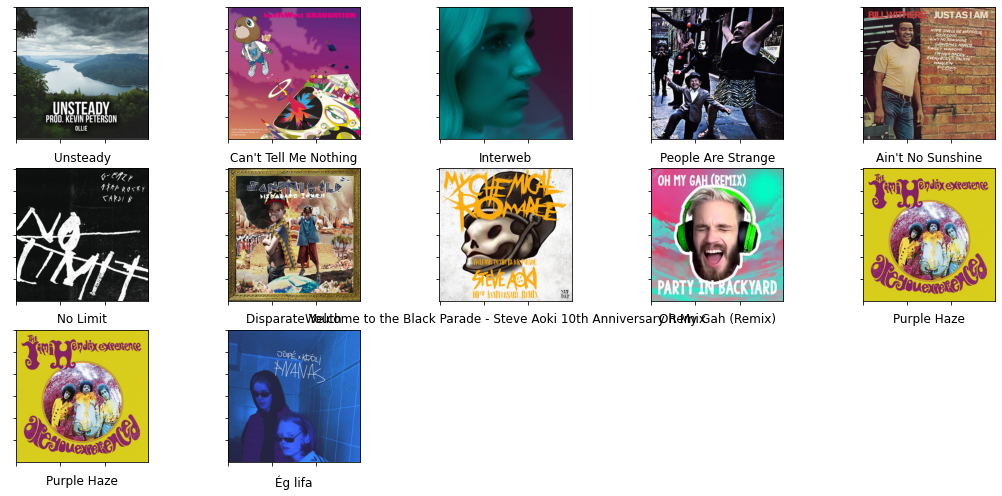

In [21]:
cover_songs(outliers_df)

## Extra

In [22]:
## show all recommendations

In [23]:
## show bad recommendations (low popularity)

In [24]:
## show good recommendations (high popularity)